In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = "data_files\IK_50LMRD_cyc1_entropy\IK_50LMRD_entropy_C01_cropped.mpt"

data = pd.read_csv(path, sep="\t")
print(data.head())



   mode  ox/red  error  control changes  Ns changes  counter inc.  Ns  \
0     3       0      1                0           1             0   0   
1     3       0      0                0           0             0   0   
2     3       0      0                0           0             0   0   
3     3       0      0                0           0             0   0   
4     3       0      0                0           0             0   0   

   I Range  time/s  control/mA  ...  Capacitance discharge/�F  step time/s  \
0       39     0.0         0.0  ...                       0.0          0.0   
1       39     1.0         0.0  ...                       0.0          0.0   
2       39     2.0         0.0  ...                       0.0          0.0   
3       39     3.0         0.0  ...                       0.0          0.0   
4       39     4.0         0.0  ...                       0.0          0.0   

   Q discharge/mA.h  Q charge/mA.h  Capacity/mA.h  Efficiency/%  cycle number  \
0          

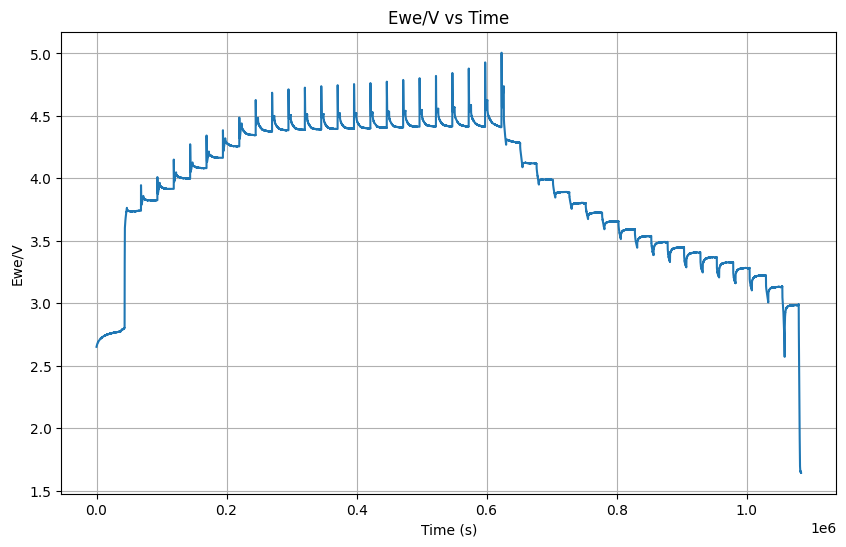

In [3]:
time = data["time/s"].to_numpy()
ewe = data["Ewe/V"].to_numpy()
capacity = data["Capacity/mA.h"].to_numpy()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time, ewe)
plt.xlabel('Time (s)')
plt.ylabel('Ewe/V')
plt.title('Ewe/V vs Time')
plt.grid(True)

# Show the plot
plt.show()

# Optionally, save the plot
# plt.savefig('ewe_vs_time.png')

In [4]:
print(len(ewe))
print(len(time))
print(len(capacity))

# Downsample ewe and time to give a reading every hour
ewe_hourly = ewe[::3600]
time_hourly = time[::3600]
capacity_hourly = capacity[::3600]
time_hourly = time_hourly/3600
time_hourly = time_hourly.round()

print(len(ewe_hourly))
print(len(time_hourly))
print(len(capacity_hourly))
print(time_hourly)

1083688
1083688
1083688
302
302
302
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 

In [16]:
# Create a pandas dataframe that will outputted to a csv with the following headers:
# Time (h)	Peak  potential	Temperature	OCV	dE/dT	dS	Capacity (mAh)	Capacity corresponding to peak  potential (mAh/g)

# Create a dictionary with the data
times = []
peak_potential = []
temp = []
OCV = []
dE_dT = []
dS = []
capacity_peak_pot = []
mass = 0.0121884 # mass of the electrode in g
cycle_temps = [45, 35, 25, 15, 5]

for v, t, c in zip(ewe_hourly, time_hourly, capacity_hourly):
    if t < 13 or t==174 or t>300: 
        # ignore the first 12 hours and one hour derp in transition between charge and discharge
        #end analysis at 300 hours
        continue
    if t <174:
        cycle_time_h = int((t-13) % 7)
    else:
        cycle_time_h = int(t%7) # discharge starts at 175, and 175%7 is already 0!
    print("AT cycle time: ", cycle_time_h)
    if cycle_time_h == 0:
        print("At peak potential  time", v)
        times.append(t)
        peak_potential.append(v)
        temp.append(' ')
        OCV.append(' ')
        dE_dT.append(' ')
        dS.append(' ')
        capacity_peak_pot.append(c/mass)

    # ignore hour 2 (we read only after the seconf 45C hour) for charge
    # for discharge ignore hour 6 (right now, can try adding a reading of 45c then as well)
    elif (t<175 and cycle_time_h >=2 and cycle_time_h <= 6) or (t>175 and cycle_time_h >=1 and cycle_time_h<=5): # or cycle_time_h == 0:
        times.append(' ')
        peak_potential.append(' ')
        if t<175:
            temp.append(cycle_temps[cycle_time_h-2])
        else:
            temp.append(cycle_temps[cycle_time_h-1])
        OCV.append(ewe[int(t)*3600-1])
        dE_dT.append(' ')
        dS.append(' ')
        capacity_peak_pot.append(' ')

    #find slope of line of best fit of the five points
    if cycle_time_h == 6:
        print("OCV: ", OCV[-5:])
        print("cycle temps", cycle_temps)
        m, b = np.polyfit(cycle_temps, OCV[-5:], 1)
        dE_dT[-6] = m
        dS[-6] = -m*96500

        
condensed_peak_pot = [x for x in peak_potential if x != ' ']
condensed_ds = [x for x in dS if x != ' ']
condensed_capacity = [x for x in capacity_peak_pot if x != ' ']
theoretical_capacity = 378 # mAh/g
soc = [x/theoretical_capacity for x in condensed_capacity]

# Pad condensed dictionaries to be the same length
length = len(times)
for d in [condensed_peak_pot, condensed_ds, condensed_capacity, soc]:
    while len(d) < length:
        d.append(' ')


empty_dummy = [' ']*length

data_dict = {
    'Time (h)': times,
    'Peak potential': peak_potential,
    'Temperature': temp,
    'OCV': OCV,
    'dE/dT': dE_dT,
    'dS': dS,
    'Capacity corresponding to peak  potential (mAh/g)': capacity_peak_pot,
    ' ': empty_dummy,
    'Condensed peak potential': condensed_peak_pot,
    'Condensed dS': condensed_ds,
    'Condensed capacity': condensed_capacity,
    'State of charge': soc
}


AT cycle time:  0
At peak potential  time 3.7635453
AT cycle time:  1
AT cycle time:  2
AT cycle time:  3
AT cycle time:  4
AT cycle time:  5
AT cycle time:  6
OCV:  [3.7345707, 3.7353418, 3.7368417, 3.7385287, 3.7401853]
cycle temps [45, 35, 25, 15, 5]
AT cycle time:  0
At peak potential  time 3.8587551
AT cycle time:  1
AT cycle time:  2
AT cycle time:  3
AT cycle time:  4
AT cycle time:  5
AT cycle time:  6
OCV:  [3.8235409, 3.8228388, 3.8231363, 3.8237472, 3.8244534]
cycle temps [45, 35, 25, 15, 5]
AT cycle time:  0
At peak potential  time 3.9638095
AT cycle time:  1
AT cycle time:  2
AT cycle time:  3
AT cycle time:  4
AT cycle time:  5
AT cycle time:  6
OCV:  [3.9181755, 3.9156754, 3.9150801, 3.9152441, 3.9155304]
cycle temps [45, 35, 25, 15, 5]
AT cycle time:  0
At peak potential  time 4.047574
AT cycle time:  1
AT cycle time:  2
AT cycle time:  3
AT cycle time:  4
AT cycle time:  5
AT cycle time:  6
OCV:  [4.0043826, 4.0014205, 4.0001726, 3.9997566, 3.9994969]
cycle temps [45, 

In [17]:
# print the lengths of all the lists in data_dict
for key in data_dict:
    print(key, len(data_dict[key]))

Time (h) 246
Peak potential 246
Temperature 246
OCV 246
dE/dT 246
dS 246
Capacity corresponding to peak  potential (mAh/g) 246
  246
Condensed peak potential 246
Condensed dS 246
Condensed capacity 246
State of charge 246


In [18]:
# Export to csv
df = pd.DataFrame(data_dict)
df.to_csv('output.csv', index=False)